# Day x
batch size 256 lr 1e-3, normed weighted, non-rotated, cartesian, SWA renwal test

### Import modules

In [1]:
%matplotlib inline
from __future__ import division
import sys
import os
#os.environ['MKL_THREADING_LAYER']='GNU'
sys.path.append('../')
from Modules.Basics import *
from Modules.Class_Basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/giles/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5560611034690493040
]


## Options

In [3]:
classTrainFeatures = ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']
classModel = 'modelSwish'
varSet = "basic_features"

nSplits = 10
ensembleSize = 10
ensembleMode = 'loss'

maxEpochs = 200
compileArgs = {'loss':'binary_crossentropy', 'optimizer':'adam'}
trainParams = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
modelParams = {'version':classModel, 'nIn':len(classTrainFeatures), 'compileArgs':compileArgs, 'mode':'classifier'}

print("\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(dirLoc + 'inputPipe.pkl', 'rb') as fin:
    inputPipe = pickle.load(fin)

In [6]:
trainData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'train.hdf5', "r+"),
                                    inputPipe=inputPipe, augRotMult=16)

## Determine LR

2 classes found, running in binary mode


______________________________________
Training finished
Cross-validation took 1.299s 


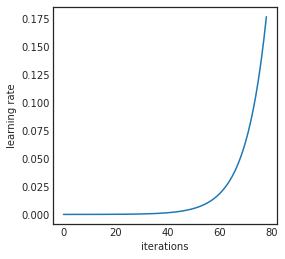

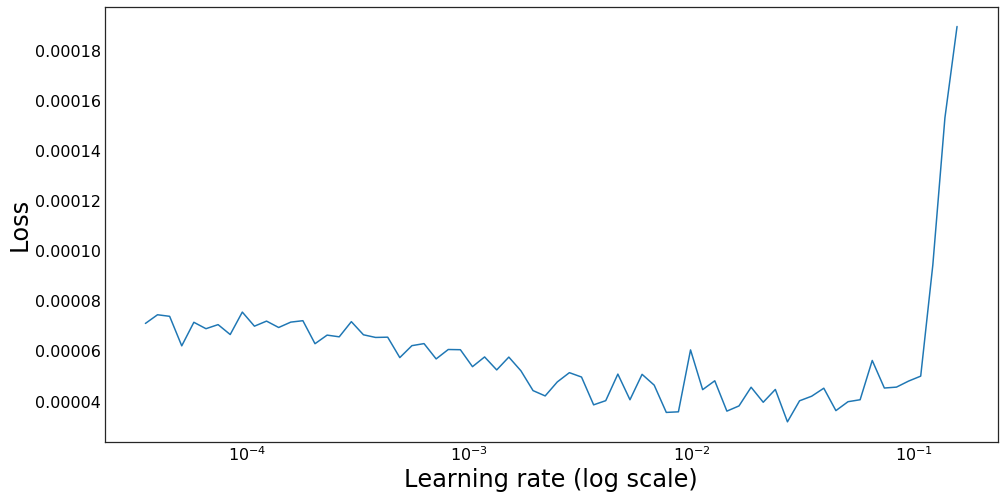

______________________________________



In [7]:
lrFinder = batchLRFind(trainData, getModel, modelParams, trainParams,
                       lrBounds=[1e-5,2e-1], trainOnWeights=True, verbose=0)

In [12]:
compileArgs['lr'] = 1e-3

In [13]:
def _batchTrainClassifier(batchYielder, nSplits, modelGen, modelGenParams, trainParams,
                         cosAnnealMult=0, reverseAnneal=False, plotLR=False, reduxDecay=False,
                         annealMomentum=False, reverseAnnealMomentum=False, plotMomentum=False,
                         oneCycle=False, ratio=0.25, reverse=False, lrScale=10, momScale=10, plotOneCycle=False, scale=30, mode='sgd',
                         swaStart=-1, swaRenewal=-1,
                         trainOnWeights=True,
                         saveLoc='train_weights/', patience=10, maxEpochs=10000,
                         verbose=False, logoutput=False):
    
    os.system("mkdir " + saveLoc)
    os.system("rm " + saveLoc + "*.h5")
    os.system("rm " + saveLoc + "*.json")
    os.system("rm " + saveLoc + "*.pkl")
    os.system("rm " + saveLoc + "*.png")
    os.system("rm " + saveLoc + "*.log")
    
    if logoutput:
        old_stdout = sys.stdout
        log_file = open(saveLoc + 'training_log.log', 'w')
        sys.stdout = log_file

    start = timeit.default_timer()
    results = []
    histories = []
    binary = None

    if not isinstance(batchYielder, BatchYielder):
        print ("HDF5 as input is depreciated, converting to BatchYielder")
        batchYielder = BatchYielder(batchYielder)

    if cosAnnealMult: print ("Using cosine annealing")
    if trainOnWeights: print ("Training using weights")

    for fold in range(nSplits):
        foldStart = timeit.default_timer()
        print ("Running fold", fold+1, "/", nSplits)
        os.system("rm " + saveLoc + "best.h5")
        best = -1
        bestLR = -1
        reduxDecayActive = False
        tmpPatience = patience
        epochCounter = 0
        subEpoch = 0
        stop = False
        lossHistory = {'val_loss':[], 'swa_val_loss':[]}
        trainID, testID = getFolds(fold, nSplits) #Get fold indeces for training and testing for current fold

        model = None
        model = modelGen(**modelGenParams)
        model.reset_states #Just checking
        
        testbatch = batchYielder.getBatch(testID) #Load testing fold

        callbacks = []
        if cosAnnealMult:
            cosAnneal = CosAnneal(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnneal)
            callbacks.append(cosAnneal)
        
        if annealMomentum:
            cosAnnealMomentum = CosAnnealMomentum(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), cosAnnealMult, reverseAnnealMomentum)
            callbacks.append(cosAnnealMomentum)    

        if oneCycle:
            oneCycle = OneCycle(math.ceil(len(batchYielder.source['fold_0/targets'])/trainParams['batch_size']), ratio=ratio, reverse=reverse, lrScale=lrScale, momScale=momScale, scale=scale, mode=mode)
            callbacks.append(oneCycle)  
        
        if swaStart >= 0:
            if cosAnnealMult:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, cosAnneal, trainOnWeights=trainOnWeights)
            else:
                swa = _SWA(swaStart, testbatch, modelGen(**modelGenParams), verbose, swaRenewal, trainOnWeights=trainOnWeights)
            callbacks.append(swa)
        useSWA = False

        for epoch in range(maxEpochs):
            for n in trainID: #Loop through training folds
                trainbatch = batchYielder.getBatch(n) #Load fold data
                subEpoch += 1
                
                if binary == None: #First run, check classification mode
                    binary = True
                    nClasses = len(np.unique(trainbatch['targets']))
                    if nClasses > 2:
                        print (nClasses, "classes found, running in multiclass mode\n")
                        trainbatch['targets'] = utils.to_categorical(trainbatch['targets'], num_classes=nClasses)
                        binary = False
                    else:
                        print (nClasses, "classes found, running in binary mode\n")

                if trainOnWeights:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto', sample_weight=trainbatch['weights'],
                              callbacks = callbacks, **trainParams) #Train for one epoch

                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                        
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], sample_weight=testbatch['weights'], verbose=0)
                    
                else:
                    model.fit(trainbatch['inputs'], trainbatch['targets'],
                              class_weight = 'auto',
                              callbacks = callbacks, **trainParams) #Train for one epoch
                    
                    if swaStart >= 0 and swa.active:
                        losses = swa.get_losses()
                        print('{} swa loss {}, default loss {}'.format(subEpoch, losses['swa'], losses['base']))
                        if losses['swa'] < losses['base']:
                            loss = losses['swa']
                            useSWA = True
                        else:
                            loss = losses['base']
                            useSWA = False
                    else:
                        loss = model.evaluate(testbatch['inputs'], testbatch['targets'], verbose=0)
                
                if swaStart >= 0 and swa.active and cosAnnealMult > 1:
                    print ("{} SWA loss:", subEpoch, loss)
                
                if swaStart >= 0:
                    if swa.active:
                        lossHistory['swa_val_loss'].append(losses['swa'])
                        lossHistory['val_loss'].append(losses['base'])
                    else:
                        lossHistory['swa_val_loss'].append(loss)
                        lossHistory['val_loss'].append(loss)
                else:
                    lossHistory['val_loss'].append(loss)        

                if loss <= best or best < 0: #Save best
                    best = loss
                    if cosAnnealMult:
                        if cosAnneal.lrs[-1] > 0:
                            bestLR = cosAnneal.lrs[-1]
                        else:
                            bestLR = cosAnneal.lrs[-2]
                    epochCounter = 0
                    if swaStart >= 0 and swa.active and useSWA:
                        swa.test_model.save_weights(saveLoc + "best.h5")
                    else:
                        model.save_weights(saveLoc + "best.h5")
                    if reduxDecayActive:
                        cosAnneal.lrs.append(float(K.get_value(model.optimizer.lr)))
                    if verbose:
                        print ('{} New best found: {}'.format(subEpoch, best))
                elif cosAnnealMult and not reduxDecayActive:
                    if cosAnneal.cycle_end:
                        epochCounter += 1
                else:
                    epochCounter += 1
                    if reduxDecayActive:
                        lr = 0.8*float(K.get_value(model.optimizer.lr))
                        cosAnneal.lrs.append(lr)
                        K.set_value(model.optimizer.lr, lr)

                if epochCounter >= tmpPatience: #Early stopping
                    if cosAnnealMult and reduxDecay and not reduxDecayActive:
                        print ('CosineAnneal stalling after {} epochs, entering redux decay at LR={}'.format(subEpoch, bestLR))
                        model.load_weights(saveLoc +  "best.h5")
                        cosAnneal.lrs.append(bestLR)
                        K.set_value(model.optimizer.lr, bestLR)
                        tmpPatience = 10
                        epochCounter = 0
                        callbacks = []
                        reduxDecayActive = True
                    else:
                        if verbose:
                            print ('Early stopping after {} epochs'.format(subEpoch))
                        stop = True
                        break
            
            if stop:
                break

        model.load_weights(saveLoc +  "best.h5")

        histories.append({})
        histories[-1]['val_loss'] = lossHistory['val_loss']
        if swaStart >= 0:
            histories[-1]['swa_val_loss'] = lossHistory['swa_val_loss']
        
        results.append({})
        results[-1]['loss'] = best
        if binary:
            testbatch = batchYielder.getBatch(testID) #Load testing fold
            if not isinstance(testbatch['weights'], type(None)):
                results[-1]['wAUC'] = 1-roc_auc_score(testbatch['targets'],
                                                     model.predict(testbatch['inputs'], verbose=0),
                                                     sample_weight=testbatch['weights'])
            results[-1]['AUC'] = 1-roc_auc_score(testbatch['targets'],
                                                 model.predict(testbatch['inputs'], verbose=0))
        print ("Score is:", results[-1])

        if plotLR: cosAnneal.plot_lr()
        if plotMomentum: cosAnnealMomentum.plot_momentum()
        if plotOneCycle: oneCycle.plot()

        print("Fold took {:.3f}s\n".format(timeit.default_timer() - foldStart))

        model.save(saveLoc +  'train_' + str(fold) + '.h5')
        with open(saveLoc +  'resultsFile.pkl', 'wb') as fout: #Save results
            pickle.dump(results, fout)

    print("\n______________________________________")
    print("Training finished")
    print("Cross-validation took {:.3f}s ".format(timeit.default_timer() - start))
    plotTrainingHistory(histories, save=saveLoc + 'loss_history.png')
    for score in results[0]:
        mean = uncertRound(np.mean([x[score] for x in results]), np.std([x[score] for x in results])/np.sqrt(len(results)))
        print ("Mean", score, "= {} +- {}".format(mean[0], mean[1]))
    print("______________________________________\n")
                      
    if logoutput:
        sys.stdout = old_stdout
        log_file.close()
    return results, histories

In [14]:
class _SWA(Callback):
    '''Based on fastai version'''
    def __init__(self, swa_start, testBatch, testModel, verbose=False, swaRenewal=-1,
                 clrCallback=None, trainOnWeights=False, sgdReplacement=False):
        super(_SWA, self).__init__()
        self.swa_model = None
        self.swa_model_new = None
        self.swa_start = swa_start
        self.epoch = -1
        self.swa_n = -1
        self.swaRenewal = swaRenewal
        self.n_since_renewal = -1
        self.losses = {'swa':None, 'base':None}
        self.active = False
        self.testBatch = testBatch
        self.weighted = trainOnWeights
        self.clrCallback = clrCallback
        self.test_model = testModel
        self.verbose = verbose
        self.sgdReplacement = sgdReplacement
        
    def on_train_begin(self, logs={}):
        if isinstance(self.swa_model, type(None)):
            self.swa_model = self.model.get_weights()
            self.swa_model_new = self.model.get_weights()
            self.epoch = 0
            self.swa_n = 0
            self.n_since_renewal = 0
            self.first_completed= False
            self.cylcle_since_replacement = 1
            
    def on_epoch_begin(self, metrics, logs={}):
        self.losses = {'swa':None, 'base':None}

    def on_epoch_end(self, metrics, logs={}):
        if (self.epoch + 1) >= self.swa_start and (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end):
            if self.swa_n == 0:
                print ("SWA beginning")
                self.active = True
            elif not isinstance(self.clrCallback, type(None)) and self.clrCallback.cycle_mult > 1:
                print ("Updating average")
                self.active = True
            self.update_average_model()
            self.swa_n += 1
            
            if self.swa_n > self.swaRenewal:
                self.first_completed = True
                self.n_since_renewal += 1
                if self.n_since_renewal > self.cylcle_since_replacement*self.swaRenewal and self.swaRenewal > 0:
                    self.compareAverages()
            
        if isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end:
            self.epoch += 1

        if self.active and not (isinstance(self.clrCallback, type(None)) or self.clrCallback.cycle_end or self.clrCallback.cycle_mult == 1):
            self.active = False
            
    def update_average_model(self):
        # update running average of parameters
        print("model is {} epochs old".format(self.swa_n))
        for model_param, swa_param in zip(self.model.get_weights(), self.swa_model):
            swa_param *= self.swa_n
            swa_param += model_param
            swa_param /= (self.swa_n + 1)
        
        if self.swa_n > self.swaRenewal and self.first_completed:
            print("new model is {} epochs old".format(self.n_since_renewal))
            for model_param, swa_param in zip(self.model.get_weights(), self.swa_model_new):
                swa_param *= self.n_since_renewal
                swa_param += model_param
                swa_param /= (self.n_since_renewal + 1)
            
    def compareAverages(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        self.test_model.set_weights(self.swa_model_new)
        if self.weighted:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
        else:
            new_loss = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        print("Checking renewal swa model, current model: {}, new model: {}".format(self.losses['swa'], new_loss))
        if new_loss < self.losses['swa']:
            print("New model better, replacing\n____________________\n\n")
            self.losses['swa'] = new_loss
            if self.sgdReplacement:
                self.model.set_weights(self.swa_model)
                self.n_since_renewal = 0
            else:
                self.n_since_renewal = 1
            self.swa_model[:] = self.swa_model_new
            self.swa_model_new = self.model.get_weights()
            self.swa_n = self.n_since_renewal
            self.cylcle_since_replacement = 1

        else:
            print("Current model better, renewing\n____________________\n\n")
            self.swa_model_new = self.model.get_weights()
            self.n_since_renewal = 1
            self.test_model.set_weights(self.swa_model)
            self.cylcle_since_replacement += 1
                
    
    def get_losses(self):
        if isinstance(self.losses['swa'], type(None)):
            self.test_model.set_weights(self.swa_model)
            if self.weighted:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['swa'] = self.test_model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        if isinstance(self.losses['base'], type(None)):
            if self.weighted:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], sample_weight=self.testBatch['weights'], verbose=0)
            else:
                self.losses['base'] = self.model.evaluate(self.testBatch['inputs'], self.testBatch['targets'], verbose=0)
        
        return self.losses

## Train classifier

Using cosine annealing
Training using weights
Running fold 1 / 10
2 classes found, running in binary mode

SWA beginning
model is 0 epochs old
1 swa loss 4.321817360271746e-05, default loss 4.321817360271746e-05
1 New best found: 4.321817360271746e-05
model is 1 epochs old
2 swa loss 4.0467146880449126e-05, default loss 3.848574001454951e-05
2 New best found: 3.848574001454951e-05
model is 2 epochs old
3 swa loss 3.8999958683129766e-05, default loss 3.703141932081399e-05
3 New best found: 3.703141932081399e-05
model is 3 epochs old
4 swa loss 3.812416391119111e-05, default loss 3.6433577639521964e-05
4 New best found: 3.6433577639521964e-05
model is 4 epochs old
5 swa loss 3.75066395869808e-05, default loss 3.594225647331446e-05
5 New best found: 3.594225647331446e-05
model is 5 epochs old
6 swa loss 3.7090482438658405e-05, default loss 3.5779498309773765e-05
6 New best found: 3.5779498309773765e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.671316395923256e-05, defau

51 swa loss 3.307158895007633e-05, default loss 3.3323301183802446e-05
model is 3 epochs old
52 swa loss 3.3035364306138836e-05, default loss 3.3294596071037984e-05
52 New best found: 3.3035364306138836e-05
model is 4 epochs old
53 swa loss 3.2996009150664344e-05, default loss 3.306143082729986e-05
53 New best found: 3.2996009150664344e-05
model is 5 epochs old
54 swa loss 3.297283413748443e-05, default loss 3.3089176817697895e-05
54 New best found: 3.297283413748443e-05
model is 6 epochs old
new model is 2 epochs old
55 swa loss 3.2974211719578535e-05, default loss 3.320889793224352e-05
model is 7 epochs old
new model is 3 epochs old
56 swa loss 3.29795199943493e-05, default loss 3.334289189922245e-05
model is 8 epochs old
new model is 4 epochs old
57 swa loss 3.2966693951456665e-05, default loss 3.3156209346568197e-05
57 New best found: 3.2966693951456665e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.295597166268745e-05, new model: 3

model is 17 epochs old
new model is 8 epochs old
104 swa loss 3.255953853071147e-05, default loss 3.276959320717573e-05
104 New best found: 3.255953853071147e-05
model is 18 epochs old
new model is 9 epochs old
105 swa loss 3.25594153532609e-05, default loss 3.2943543970201755e-05
105 New best found: 3.25594153532609e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2549467278882766e-05, new model: 3.253755797063604e-05
New model better, replacing
____________________


106 swa loss 3.253755797063604e-05, default loss 3.267541655768536e-05
106 New best found: 3.253755797063604e-05
model is 1 epochs old
107 swa loss 3.255799626892441e-05, default loss 3.2763076421460954e-05
model is 2 epochs old
108 swa loss 3.257683449267537e-05, default loss 3.3029156626215414e-05
model is 3 epochs old
109 swa loss 3.2540021638337034e-05, default loss 3.268367638588189e-05
model is 4 epochs old
110 swa loss 3.2569405436692593e-05, default loss 3.3030879

161 swa loss 3.2405554002123784e-05, default loss 3.254633748997566e-05
model is 4 epochs old
162 swa loss 3.2376094721008004e-05, default loss 3.245800994056081e-05
model is 5 epochs old
163 swa loss 3.235047789995927e-05, default loss 3.247939418279501e-05
163 New best found: 3.235047789995927e-05
model is 6 epochs old
new model is 2 epochs old
164 swa loss 3.2368284580664676e-05, default loss 3.2780179279419165e-05
model is 7 epochs old
new model is 3 epochs old
165 swa loss 3.238436545644016e-05, default loss 3.282045313373888e-05
model is 8 epochs old
new model is 4 epochs old
166 swa loss 3.2372540289690816e-05, default loss 3.256113889647513e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.2368721324387386e-05, new model: 3.2434248351152694e-05
Current model better, renewing
____________________


167 swa loss 3.2368721324387386e-05, default loss 3.26496548618309e-05
model is 10 epochs old
new model is 1 epochs old
168 swa loss 3.2

model is 8 epochs old
new model is 4 epochs old
219 swa loss 3.223065973714105e-05, default loss 3.2705058578006865e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.221880866264436e-05, new model: 3.225932738635344e-05
Current model better, renewing
____________________


220 swa loss 3.221880866264436e-05, default loss 3.2515701439651774e-05
model is 10 epochs old
new model is 1 epochs old
221 swa loss 3.221313455327281e-05, default loss 3.2428112869395296e-05
model is 11 epochs old
new model is 2 epochs old
222 swa loss 3.222297930706226e-05, default loss 3.2616489260914234e-05
model is 12 epochs old
new model is 3 epochs old
223 swa loss 3.221155412001342e-05, default loss 3.242189152437161e-05
model is 13 epochs old
new model is 4 epochs old
224 swa loss 3.220411994995109e-05, default loss 3.238956428413208e-05
model is 14 epochs old
new model is 5 epochs old
225 swa loss 3.219537957967138e-05, default loss 3.239721838012368e-05
model

277 swa loss 3.215610608814248e-05, default loss 3.2411434945706484e-05
277 New best found: 3.215610608814248e-05
model is 67 epochs old
new model is 13 epochs old
278 swa loss 3.2153027835712104e-05, default loss 3.2228922357237995e-05
278 New best found: 3.2153027835712104e-05
model is 68 epochs old
new model is 14 epochs old
279 swa loss 3.2150708024838346e-05, default loss 3.232598597326462e-05
279 New best found: 3.2150708024838346e-05
model is 69 epochs old
new model is 15 epochs old
280 swa loss 3.214856338841176e-05, default loss 3.2277465771349464e-05
280 New best found: 3.214856338841176e-05
model is 70 epochs old
new model is 16 epochs old
281 swa loss 3.214947067750021e-05, default loss 3.258991011588448e-05
model is 71 epochs old
new model is 17 epochs old
282 swa loss 3.214768553996545e-05, default loss 3.239467901371126e-05
282 New best found: 3.214768553996545e-05
model is 72 epochs old
new model is 18 epochs old
283 swa loss 3.214544368282937e-05, default loss 3.237806

model is 121 epochs old
new model is 12 epochs old
332 swa loss 3.211993977276011e-05, default loss 3.238902243767606e-05
332 New best found: 3.211993977276011e-05
model is 122 epochs old
new model is 13 epochs old
333 swa loss 3.2118460012635094e-05, default loss 3.232329933118968e-05
333 New best found: 3.2118460012635094e-05
model is 123 epochs old
new model is 14 epochs old
334 swa loss 3.211708703521672e-05, default loss 3.234163786366536e-05
334 New best found: 3.211708703521672e-05
model is 124 epochs old
new model is 15 epochs old
335 swa loss 3.2117090478583336e-05, default loss 3.24860851024227e-05
model is 125 epochs old
new model is 16 epochs old
336 swa loss 3.211532920607739e-05, default loss 3.246096895393217e-05
336 New best found: 3.211532920607739e-05
model is 126 epochs old
new model is 17 epochs old
337 swa loss 3.21157899307034e-05, default loss 3.257420641634738e-05
model is 127 epochs old
new model is 18 epochs old
338 swa loss 3.211622819531014e-05, default loss

model is 35 epochs old
new model is 1 epochs old
390 swa loss 3.212184124270566e-05, default loss 3.2432235268325936e-05
model is 36 epochs old
new model is 2 epochs old
391 swa loss 3.212422030345654e-05, default loss 3.252377028054485e-05
model is 37 epochs old
new model is 3 epochs old
392 swa loss 3.2121472082237146e-05, default loss 3.261549291474751e-05
model is 38 epochs old
new model is 4 epochs old
393 swa loss 3.2123334463397954e-05, default loss 3.2506513193111715e-05
model is 39 epochs old
new model is 5 epochs old
394 swa loss 3.212536038403863e-05, default loss 3.253482502338021e-05
model is 40 epochs old
new model is 6 epochs old
395 swa loss 3.2121307531742645e-05, default loss 3.256238058911017e-05
model is 41 epochs old
new model is 7 epochs old
396 swa loss 3.212101784879239e-05, default loss 3.255449757884964e-05
model is 42 epochs old
new model is 8 epochs old
397 swa loss 3.2119140904279145e-05, default loss 3.24076504413815e-05
model is 43 epochs old
new model is

39 swa loss 3.288081089026925e-05, default loss 3.29917482922443e-05
39 New best found: 3.288081089026925e-05
model is 1 epochs old
40 swa loss 3.2895882499300846e-05, default loss 3.312412036727875e-05
model is 2 epochs old
41 swa loss 3.294478105083999e-05, default loss 3.3350101494835097e-05
model is 3 epochs old
42 swa loss 3.288772234631639e-05, default loss 3.2940539110073735e-05
model is 4 epochs old
43 swa loss 3.2835082349772956e-05, default loss 3.2911807281252694e-05
43 New best found: 3.2835082349772956e-05
model is 5 epochs old
44 swa loss 3.2823627241813564e-05, default loss 3.3036770292309e-05
44 New best found: 3.2823627241813564e-05
model is 6 epochs old
new model is 2 epochs old
45 swa loss 3.2813549758861494e-05, default loss 3.318107799462599e-05
45 New best found: 3.2813549758861494e-05
model is 7 epochs old
new model is 3 epochs old
46 swa loss 3.27779271857446e-05, default loss 3.291697224337973e-05
46 New best found: 3.27779271857446e-05
model is 8 epochs old
ne

Checking renewal swa model, current model: 3.2410933239306644e-05, new model: 3.2331249191421356e-05
New model better, replacing
____________________


92 swa loss 3.2331249191421356e-05, default loss 3.249707454417239e-05
92 New best found: 3.2331249191421356e-05
model is 1 epochs old
93 swa loss 3.2358785354653805e-05, default loss 3.254361178295243e-05
model is 2 epochs old
94 swa loss 3.236047933714592e-05, default loss 3.2647059253224066e-05
model is 3 epochs old
95 swa loss 3.23807900123877e-05, default loss 3.277207543592303e-05
model is 4 epochs old
96 swa loss 3.23715980831138e-05, default loss 3.2745751153986294e-05
model is 5 epochs old
97 swa loss 3.236378545741767e-05, default loss 3.2686920452733196e-05
model is 6 epochs old
new model is 2 epochs old
98 swa loss 3.235941084316255e-05, default loss 3.265075840353027e-05
model is 7 epochs old
new model is 3 epochs old
99 swa loss 3.2351652630905145e-05, default loss 3.269342258043803e-05
model is 8 epochs old
new model is 4

144 swa loss 3.209475829084197e-05, default loss 3.235369306788222e-05
144 New best found: 3.209475829084197e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.208942319924125e-05, new model: 3.207385963993958e-05
New model better, replacing
____________________


145 swa loss 3.207385963993958e-05, default loss 3.235324558031781e-05
145 New best found: 3.207385963993958e-05
model is 1 epochs old
146 swa loss 3.2091259625446665e-05, default loss 3.225810675799173e-05
model is 2 epochs old
147 swa loss 3.208324771070853e-05, default loss 3.223655917168349e-05
model is 3 epochs old
148 swa loss 3.208960826497477e-05, default loss 3.227642569589281e-05
model is 4 epochs old
149 swa loss 3.20857701824979e-05, default loss 3.2458369563243946e-05
model is 5 epochs old
150 swa loss 3.2090936691450294e-05, default loss 3.2385160549172666e-05
model is 6 epochs old
new model is 2 epochs old
151 swa loss 3.2080901688417e-05, default loss 3.244674413

202 swa loss 3.2007290547130416e-05, default loss 3.224088329871726e-05
202 New best found: 3.2007290547130416e-05
model is 20 epochs old
new model is 1 epochs old
203 swa loss 3.201007687038782e-05, default loss 3.246514644954374e-05
model is 21 epochs old
new model is 2 epochs old
204 swa loss 3.200734082845815e-05, default loss 3.231656746393371e-05
model is 22 epochs old
new model is 3 epochs old
205 swa loss 3.200200548645196e-05, default loss 3.217518189960063e-05
205 New best found: 3.200200548645196e-05
model is 23 epochs old
new model is 4 epochs old
206 swa loss 3.2001174476741215e-05, default loss 3.2444785411180635e-05
206 New best found: 3.2001174476741215e-05
model is 24 epochs old
new model is 5 epochs old
207 swa loss 3.199558408305226e-05, default loss 3.2163204253313865e-05
207 New best found: 3.199558408305226e-05
model is 25 epochs old
new model is 6 epochs old
208 swa loss 3.198976954420419e-05, default loss 3.22116239931629e-05
208 New best found: 3.19897695442041

model is 1 epochs old
261 swa loss 3.1982031199876964e-05, default loss 3.2254868648197724e-05
model is 2 epochs old
262 swa loss 3.198043147369769e-05, default loss 3.221333708649144e-05
model is 3 epochs old
263 swa loss 3.1968172344177845e-05, default loss 3.217292270874769e-05
model is 4 epochs old
264 swa loss 3.195952771457813e-05, default loss 3.218733176812879e-05
model is 5 epochs old
265 swa loss 3.195247609996804e-05, default loss 3.21270970991883e-05
model is 6 epochs old
new model is 2 epochs old
266 swa loss 3.194700709552652e-05, default loss 3.233260686385151e-05
model is 7 epochs old
new model is 3 epochs old
267 swa loss 3.194315132076076e-05, default loss 3.226443692221621e-05
model is 8 epochs old
new model is 4 epochs old
268 swa loss 3.194162872119072e-05, default loss 3.2172623643394125e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.193649526329444e-05, new model: 3.19961439042451e-05
Current model better, renewin

model is 59 epochs old
new model is 5 epochs old
319 swa loss 3.189474433861436e-05, default loss 3.2209760134330937e-05
319 New best found: 3.189474433861436e-05
model is 60 epochs old
new model is 6 epochs old
320 swa loss 3.189408650793676e-05, default loss 3.215279566542451e-05
320 New best found: 3.189408650793676e-05
model is 61 epochs old
new model is 7 epochs old
321 swa loss 3.18942863098854e-05, default loss 3.233049677162934e-05
model is 62 epochs old
new model is 8 epochs old
322 swa loss 3.189521785051752e-05, default loss 3.225280340581671e-05
model is 63 epochs old
new model is 9 epochs old
323 swa loss 3.189609208960709e-05, default loss 3.231071193065557e-05
model is 64 epochs old
new model is 10 epochs old
324 swa loss 3.18952462519576e-05, default loss 3.2347644442742375e-05
model is 65 epochs old
new model is 11 epochs old
325 swa loss 3.1895452661515285e-05, default loss 3.2303213332361405e-05
model is 66 epochs old
new model is 12 epochs old
326 swa loss 3.1897165

model is 116 epochs old
new model is 7 epochs old
376 swa loss 3.1873721088540724e-05, default loss 3.220662505627885e-05
376 New best found: 3.1873721088540724e-05
model is 117 epochs old
new model is 8 epochs old
377 swa loss 3.187311976804274e-05, default loss 3.218123071699804e-05
377 New best found: 3.187311976804274e-05
model is 118 epochs old
new model is 9 epochs old
378 swa loss 3.1872846503490977e-05, default loss 3.233762423769854e-05
378 New best found: 3.1872846503490977e-05
model is 119 epochs old
new model is 10 epochs old
379 swa loss 3.187201881843104e-05, default loss 3.2175872133317654e-05
379 New best found: 3.187201881843104e-05
model is 120 epochs old
new model is 11 epochs old
380 swa loss 3.1871096507816204e-05, default loss 3.2092770642100797e-05
380 New best found: 3.1871096507816204e-05
model is 121 epochs old
new model is 12 epochs old
381 swa loss 3.186968454653049e-05, default loss 3.209589689554534e-05
381 New best found: 3.186968454653049e-05
model is 12

432 swa loss 3.1866199961182686e-05, default loss 3.230683686772783e-05
model is 29 epochs old
new model is 10 epochs old
433 swa loss 3.1854658049272805e-05, default loss 3.191418847680114e-05
model is 30 epochs old
new model is 11 epochs old
434 swa loss 3.1851764097951175e-05, default loss 3.206985453379794e-05
model is 31 epochs old
new model is 12 epochs old
435 swa loss 3.185025252150831e-05, default loss 3.215440306837841e-05
model is 32 epochs old
new model is 13 epochs old
436 swa loss 3.185159405760921e-05, default loss 3.2232994958246555e-05
model is 33 epochs old
new model is 14 epochs old
437 swa loss 3.184951485378425e-05, default loss 3.228912505375332e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.184736636017637e-05, new model: 3.184462237068357e-05
New model better, replacing
____________________


438 swa loss 3.184462237068357e-05, default loss 3.2052947345332054e-05
model is 1 epochs old
439 swa loss 3.19268128016

33 swa loss 3.308434466616028e-05, default loss 3.3123115048129255e-05
33 New best found: 3.308434466616028e-05
model is 13 epochs old
new model is 4 epochs old
34 swa loss 3.306274017336288e-05, default loss 3.311648553383677e-05
34 New best found: 3.306274017336288e-05
model is 14 epochs old
new model is 5 epochs old
35 swa loss 3.3048879457385354e-05, default loss 3.317681517062043e-05
35 New best found: 3.3048879457385354e-05
model is 15 epochs old
new model is 6 epochs old
36 swa loss 3.303343458144683e-05, default loss 3.313494054671461e-05
36 New best found: 3.303343458144683e-05
model is 16 epochs old
new model is 7 epochs old
37 swa loss 3.3005253788550444e-05, default loss 3.3064225448522664e-05
37 New best found: 3.3005253788550444e-05
model is 17 epochs old
new model is 8 epochs old
38 swa loss 3.298649005673147e-05, default loss 3.3014268986761026e-05
38 New best found: 3.298649005673147e-05
model is 18 epochs old
new model is 9 epochs old
39 swa loss 3.2971566652217004e-0

model is 18 epochs old
new model is 9 epochs old
86 swa loss 3.2266291412584296e-05, default loss 3.242115961475145e-05
86 New best found: 3.2266291412584296e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.226379721949347e-05, new model: 3.227660870963603e-05
Current model better, renewing
____________________


87 swa loss 3.226379721949347e-05, default loss 3.261653541089495e-05
87 New best found: 3.226379721949347e-05
model is 20 epochs old
new model is 1 epochs old
88 swa loss 3.226215215537732e-05, default loss 3.2566475264776305e-05
88 New best found: 3.226215215537732e-05
model is 21 epochs old
new model is 2 epochs old
89 swa loss 3.2257247210616784e-05, default loss 3.259614390748325e-05
89 New best found: 3.2257247210616784e-05
model is 22 epochs old
new model is 3 epochs old
90 swa loss 3.224997468470695e-05, default loss 3.2502437587194976e-05
90 New best found: 3.224997468470695e-05
model is 23 epochs old
new model is 4 ep

model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1913567782232333e-05, new model: 3.1870692802223344e-05
New model better, replacing
____________________


136 swa loss 3.1870692802223344e-05, default loss 3.204445728669532e-05
136 New best found: 3.1870692802223344e-05
model is 1 epochs old
137 swa loss 3.1927758404606735e-05, default loss 3.218986856120843e-05
model is 2 epochs old
138 swa loss 3.198285423323483e-05, default loss 3.238492774202691e-05
model is 3 epochs old
139 swa loss 3.20023976289208e-05, default loss 3.232258572533761e-05
model is 4 epochs old
140 swa loss 3.198693938676148e-05, default loss 3.215865249546358e-05
model is 5 epochs old
141 swa loss 3.1994027385434055e-05, default loss 3.225448063460564e-05
model is 6 epochs old
new model is 2 epochs old
142 swa loss 3.19735735347816e-05, default loss 3.209787087372422e-05
model is 7 epochs old
new model is 3 epochs old
143 swa loss 3.198407507109349e-05, default loss 3.

196 swa loss 3.1818821072130234e-05, default loss 3.2066005243683696e-05
196 New best found: 3.1818821072130234e-05
model is 18 epochs old
new model is 9 epochs old
197 swa loss 3.182260316457561e-05, default loss 3.226831727442677e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.1820350818487674e-05, new model: 3.1848442511835935e-05
Current model better, renewing
____________________


198 swa loss 3.1820350818487674e-05, default loss 3.2085650611807866e-05
model is 20 epochs old
new model is 1 epochs old
199 swa loss 3.181380874383932e-05, default loss 3.204380448000284e-05
199 New best found: 3.181380874383932e-05
model is 21 epochs old
new model is 2 epochs old
200 swa loss 3.181066065870793e-05, default loss 3.209721374120237e-05
200 New best found: 3.181066065870793e-05
model is 22 epochs old
new model is 3 epochs old
201 swa loss 3.18062803292465e-05, default loss 3.2085784436335457e-05
201 New best found: 3.18062803292465e-05
m

model is 35 epochs old
new model is 1 epochs old
248 swa loss 3.167493656568181e-05, default loss 3.194907563846931e-05
model is 36 epochs old
new model is 2 epochs old
249 swa loss 3.16763090663065e-05, default loss 3.2015685528551335e-05
model is 37 epochs old
new model is 3 epochs old
250 swa loss 3.167473740080236e-05, default loss 3.213843667342321e-05
model is 38 epochs old
new model is 4 epochs old
251 swa loss 3.167663420750205e-05, default loss 3.204676304993172e-05
model is 39 epochs old
new model is 5 epochs old
252 swa loss 3.167417177901729e-05, default loss 3.182156995675625e-05
model is 40 epochs old
new model is 6 epochs old
253 swa loss 3.167429083021855e-05, default loss 3.206497263644187e-05
model is 41 epochs old
new model is 7 epochs old
254 swa loss 3.167416729859292e-05, default loss 3.206816416934495e-05
model is 42 epochs old
new model is 8 epochs old
255 swa loss 3.167302821435403e-05, default loss 3.197299065786282e-05
model is 43 epochs old
new model is 9 ep

model is 96 epochs old
new model is 17 epochs old
309 swa loss 3.1652858330617764e-05, default loss 3.192906766686684e-05
309 New best found: 3.1652858330617764e-05
model is 97 epochs old
new model is 18 epochs old
310 swa loss 3.165158504026343e-05, default loss 3.190668291686639e-05
310 New best found: 3.165158504026343e-05
model is 98 epochs old
new model is 19 epochs old
311 swa loss 3.1650787923190374e-05, default loss 3.186201833262243e-05
311 New best found: 3.1650787923190374e-05
model is 99 epochs old
new model is 20 epochs old
312 swa loss 3.165014418816301e-05, default loss 3.2136965421208876e-05
312 New best found: 3.165014418816301e-05
model is 100 epochs old
new model is 21 epochs old
313 swa loss 3.1649474134959546e-05, default loss 3.195303266815761e-05
313 New best found: 3.1649474134959546e-05
model is 101 epochs old
new model is 22 epochs old
314 swa loss 3.1649538497454535e-05, default loss 3.2124332925510036e-05
model is 102 epochs old
new model is 23 epochs old
31

model is 3 epochs old
360 swa loss 3.169304628449211e-05, default loss 3.1909724803883316e-05
model is 4 epochs old
361 swa loss 3.167862069935559e-05, default loss 3.1940477197959996e-05
model is 5 epochs old
362 swa loss 3.16520180031222e-05, default loss 3.185758494185728e-05
model is 6 epochs old
new model is 2 epochs old
363 swa loss 3.1654386399308524e-05, default loss 3.2042871819935345e-05
model is 7 epochs old
new model is 3 epochs old
364 swa loss 3.164421132829342e-05, default loss 3.1821536092766214e-05
model is 8 epochs old
new model is 4 epochs old
365 swa loss 3.165343617357021e-05, default loss 3.2001916882178506e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.1657100869324156e-05, new model: 3.176685171333308e-05
Current model better, renewing
____________________


366 swa loss 3.1657100869324156e-05, default loss 3.205267487918577e-05
model is 10 epochs old
new model is 1 epochs old
367 swa loss 3.1654911250086767e-05,

13 swa loss 3.4753115399507805e-05, default loss 3.400484888115898e-05
model is 13 epochs old
new model is 3 epochs old
14 swa loss 3.463299327122513e-05, default loss 3.376395663508447e-05
14 New best found: 3.376395663508447e-05
model is 14 epochs old
new model is 4 epochs old
15 swa loss 3.4534166318189816e-05, default loss 3.375698253803421e-05
15 New best found: 3.375698253803421e-05
model is 15 epochs old
new model is 5 epochs old
16 swa loss 3.4451743427780456e-05, default loss 3.38409191579558e-05
model is 16 epochs old
new model is 6 epochs old
17 swa loss 3.435900913027581e-05, default loss 3.368053020094522e-05
17 New best found: 3.368053020094522e-05
model is 17 epochs old
new model is 7 epochs old
18 swa loss 3.427642672759248e-05, default loss 3.3475412624829914e-05
18 New best found: 3.3475412624829914e-05
model is 18 epochs old
new model is 8 epochs old
19 swa loss 3.4205818019108846e-05, default loss 3.36637739543221e-05
model is 19 epochs old
new model is 9 epochs old

64 swa loss 3.235659464698983e-05, default loss 3.2605776310083454e-05
64 New best found: 3.235659464698983e-05
model is 16 epochs old
new model is 7 epochs old
65 swa loss 3.235240821377374e-05, default loss 3.264074319158681e-05
65 New best found: 3.235240821377374e-05
model is 17 epochs old
new model is 8 epochs old
66 swa loss 3.235037444101181e-05, default loss 3.26264518800599e-05
66 New best found: 3.235037444101181e-05
model is 18 epochs old
new model is 9 epochs old
67 swa loss 3.2341490074759346e-05, default loss 3.2477074888447536e-05
67 New best found: 3.2341490074759346e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2336622870934663e-05, new model: 3.22976780924364e-05
New model better, replacing
____________________


68 swa loss 3.22976780924364e-05, default loss 3.266359351546271e-05
68 New best found: 3.22976780924364e-05
model is 1 epochs old
69 swa loss 3.225967056350783e-05, default loss 3.237576562678441e-05
69 Ne

model is 23 epochs old
new model is 4 epochs old
119 swa loss 3.201546941709239e-05, default loss 3.215610660408856e-05
119 New best found: 3.201546941709239e-05
model is 24 epochs old
new model is 5 epochs old
120 swa loss 3.201035662495997e-05, default loss 3.211628613498761e-05
120 New best found: 3.201035662495997e-05
model is 25 epochs old
new model is 6 epochs old
121 swa loss 3.200191656214884e-05, default loss 3.217901370808249e-05
121 New best found: 3.200191656214884e-05
model is 26 epochs old
new model is 7 epochs old
122 swa loss 3.1995246952283195e-05, default loss 3.212300169252558e-05
122 New best found: 3.1995246952283195e-05
model is 27 epochs old
new model is 8 epochs old
123 swa loss 3.199205582786817e-05, default loss 3.221135893254541e-05
123 New best found: 3.199205582786817e-05
model is 28 epochs old
new model is 9 epochs old
124 swa loss 3.1989223496930206e-05, default loss 3.221968311263481e-05
124 New best found: 3.1989223496930206e-05
model is 29 epochs old
n

model is 45 epochs old
new model is 11 epochs old
175 swa loss 3.18172013387084e-05, default loss 3.204992724931799e-05
model is 46 epochs old
new model is 12 epochs old
176 swa loss 3.181630321923876e-05, default loss 3.209404156077653e-05
model is 47 epochs old
new model is 13 epochs old
177 swa loss 3.181449025869369e-05, default loss 3.208384104800643e-05
model is 48 epochs old
new model is 14 epochs old
178 swa loss 3.1814050856337415e-05, default loss 3.213423282577423e-05
model is 49 epochs old
new model is 15 epochs old
179 swa loss 3.1813341859378854e-05, default loss 3.220039269072004e-05
model is 50 epochs old
new model is 16 epochs old
180 swa loss 3.18142851581797e-05, default loss 3.220660205406603e-05
model is 51 epochs old
new model is 17 epochs old
181 swa loss 3.181609841558384e-05, default loss 3.225750785641139e-05
model is 52 epochs old
new model is 18 epochs old
182 swa loss 3.181414850405417e-05, default loss 3.204405550495721e-05
model is 53 epochs old
new model

model is 2 epochs old
230 swa loss 3.16966568105272e-05, default loss 3.194016340494272e-05
model is 3 epochs old
231 swa loss 3.165473224798916e-05, default loss 3.1824142535333524e-05
231 New best found: 3.165473224798916e-05
model is 4 epochs old
232 swa loss 3.165723723359406e-05, default loss 3.199970782006858e-05
model is 5 epochs old
233 swa loss 3.167079293343704e-05, default loss 3.199351322909933e-05
model is 6 epochs old
new model is 2 epochs old
234 swa loss 3.1676347717439057e-05, default loss 3.192432266077958e-05
model is 7 epochs old
new model is 3 epochs old
235 swa loss 3.1672152722603645e-05, default loss 3.198394959326833e-05
model is 8 epochs old
new model is 4 epochs old
236 swa loss 3.1670996825414476e-05, default loss 3.197043140389724e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.167032025521621e-05, new model: 3.1701651254843456e-05
Current model better, renewing
____________________


237 swa loss 3.167032025

model is 10 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.551590866263723e-05, new model: 3.5927910027385225e-05
Current model better, renewing
____________________


11 swa loss 3.551590866263723e-05, default loss 3.419491579988971e-05
11 New best found: 3.419491579988971e-05
model is 11 epochs old
new model is 1 epochs old
12 swa loss 3.536016388825374e-05, default loss 3.4176506380026695e-05
12 New best found: 3.4176506380026695e-05
model is 12 epochs old
new model is 2 epochs old
13 swa loss 3.5226961511943955e-05, default loss 3.4107215589028784e-05
13 New best found: 3.4107215589028784e-05
model is 13 epochs old
new model is 3 epochs old
14 swa loss 3.508471619861666e-05, default loss 3.404198700591223e-05
14 New best found: 3.404198700591223e-05
model is 14 epochs old
new model is 4 epochs old
15 swa loss 3.495615153951803e-05, default loss 3.3832475020608396e-05
15 New best found: 3.3832475020608396e-05
model is 15 epochs old
new model is 5 e

59 swa loss 3.224784383928636e-05, default loss 3.250759855000069e-05
59 New best found: 3.224784383928636e-05
model is 1 epochs old
60 swa loss 3.228004491102183e-05, default loss 3.247035452222917e-05
model is 2 epochs old
61 swa loss 3.2281322598282714e-05, default loss 3.247023709845962e-05
model is 3 epochs old
62 swa loss 3.225338342163013e-05, default loss 3.244239648774965e-05
model is 4 epochs old
63 swa loss 3.223870650836034e-05, default loss 3.2433454768033696e-05
63 New best found: 3.223870650836034e-05
model is 5 epochs old
64 swa loss 3.2222128675493875e-05, default loss 3.2492722643655724e-05
64 New best found: 3.2222128675493875e-05
model is 6 epochs old
new model is 2 epochs old
65 swa loss 3.22013874843833e-05, default loss 3.24116502495599e-05
65 New best found: 3.22013874843833e-05
model is 7 epochs old
new model is 3 epochs old
66 swa loss 3.219325263198698e-05, default loss 3.24041145722731e-05
66 New best found: 3.219325263198698e-05
model is 8 epochs old
new mo

model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1894439905590846e-05, new model: 3.187833226111252e-05
New model better, replacing
____________________


112 swa loss 3.187833226111252e-05, default loss 3.219103223964339e-05
112 New best found: 3.187833226111252e-05
model is 1 epochs old
113 swa loss 3.1965797870361715e-05, default loss 3.2199022427084855e-05
model is 2 epochs old
114 swa loss 3.1952163903042677e-05, default loss 3.217289714957587e-05
model is 3 epochs old
115 swa loss 3.1918341614073145e-05, default loss 3.2119853451149536e-05
model is 4 epochs old
116 swa loss 3.190552775631659e-05, default loss 3.212383864884032e-05
model is 5 epochs old
117 swa loss 3.188887277501635e-05, default loss 3.210021394479554e-05
model is 6 epochs old
new model is 2 epochs old
118 swa loss 3.189200820197584e-05, default loss 3.229371907073073e-05
model is 7 epochs old
new model is 3 epochs old
119 swa loss 3.185895699716639e-05, default loss 

model is 15 epochs old
new model is 6 epochs old
165 swa loss 3.1599916350387504e-05, default loss 3.186908601201139e-05
165 New best found: 3.1599916350387504e-05
model is 16 epochs old
new model is 7 epochs old
166 swa loss 3.159742430289043e-05, default loss 3.193259444815339e-05
166 New best found: 3.159742430289043e-05
model is 17 epochs old
new model is 8 epochs old
167 swa loss 3.1597308396885634e-05, default loss 3.191623652528506e-05
167 New best found: 3.1597308396885634e-05
model is 18 epochs old
new model is 9 epochs old
168 swa loss 3.1596964433265387e-05, default loss 3.191216349223396e-05
168 New best found: 3.1596964433265387e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.159254407073604e-05, new model: 3.162204960390227e-05
Current model better, renewing
____________________


169 swa loss 3.159254407073604e-05, default loss 3.194250263914e-05
169 New best found: 3.159254407073604e-05
model is 20 epochs old
new model 

218 swa loss 3.143166954396293e-05, default loss 3.160310511884745e-05
218 New best found: 3.143166954396293e-05
model is 1 epochs old
219 swa loss 3.149800195678836e-05, default loss 3.1739573269442186e-05
model is 2 epochs old
220 swa loss 3.1541321201075335e-05, default loss 3.1969821043458066e-05
model is 3 epochs old
221 swa loss 3.1528854214411696e-05, default loss 3.179450157913379e-05
model is 4 epochs old
222 swa loss 3.153221700922586e-05, default loss 3.1796735183161214e-05
model is 5 epochs old
223 swa loss 3.152311385274515e-05, default loss 3.1898191008076535e-05
model is 6 epochs old
new model is 2 epochs old
224 swa loss 3.1528827127476686e-05, default loss 3.183408890181454e-05
model is 7 epochs old
new model is 3 epochs old
225 swa loss 3.152540593582671e-05, default loss 3.179325207456714e-05
model is 8 epochs old
new model is 4 epochs old
226 swa loss 3.15208194348088e-05, default loss 3.184905474336119e-05
model is 9 epochs old
new model is 5 epochs old
Checking re

11 swa loss 3.597738948155893e-05, default loss 3.4802871201827656e-05
11 New best found: 3.4802871201827656e-05
model is 11 epochs old
new model is 1 epochs old
12 swa loss 3.582891130790813e-05, default loss 3.503087183344178e-05
model is 12 epochs old
new model is 2 epochs old
13 swa loss 3.569196499156533e-05, default loss 3.471049379586475e-05
13 New best found: 3.471049379586475e-05
model is 13 epochs old
new model is 3 epochs old
14 swa loss 3.558880266791675e-05, default loss 3.4952501641237176e-05
model is 14 epochs old
new model is 4 epochs old
15 swa loss 3.546674812532729e-05, default loss 3.446406774019124e-05
15 New best found: 3.446406774019124e-05
model is 15 epochs old
new model is 5 epochs old
16 swa loss 3.536387240892509e-05, default loss 3.433204961474985e-05
16 New best found: 3.433204961474985e-05
model is 16 epochs old
new model is 6 epochs old
17 swa loss 3.5268709453521296e-05, default loss 3.433244048646884e-05
model is 17 epochs old
new model is 7 epochs old

model is 8 epochs old
new model is 4 epochs old
66 swa loss 3.310772779950639e-05, default loss 3.336884792370256e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.310447966359788e-05, new model: 3.322331281378865e-05
Current model better, renewing
____________________


67 swa loss 3.310447966359788e-05, default loss 3.347628553747199e-05
model is 10 epochs old
new model is 1 epochs old
68 swa loss 3.310786428701249e-05, default loss 3.3406333868333606e-05
model is 11 epochs old
new model is 2 epochs old
69 swa loss 3.3104265043220946e-05, default loss 3.358393463422544e-05
model is 12 epochs old
new model is 3 epochs old
70 swa loss 3.3083430904662234e-05, default loss 3.313111318275332e-05
model is 13 epochs old
new model is 4 epochs old
71 swa loss 3.308187550137518e-05, default loss 3.3329276443691925e-05
model is 14 epochs old
new model is 5 epochs old
72 swa loss 3.306834049144527e-05, default loss 3.319694387537311e-05
72 New best 

120 swa loss 3.275475537302555e-05, default loss 3.324796176384552e-05
model is 10 epochs old
new model is 1 epochs old
121 swa loss 3.276327860803576e-05, default loss 3.311501212010626e-05
model is 11 epochs old
new model is 2 epochs old
122 swa loss 3.276399928654428e-05, default loss 3.305773566607968e-05
model is 12 epochs old
new model is 3 epochs old
123 swa loss 3.276052718210849e-05, default loss 3.308405083225807e-05
model is 13 epochs old
new model is 4 epochs old
124 swa loss 3.2763041085127045e-05, default loss 3.319174701755401e-05
model is 14 epochs old
new model is 5 epochs old
125 swa loss 3.277443959668744e-05, default loss 3.3275476293056274e-05
model is 15 epochs old
new model is 6 epochs old
126 swa loss 3.276900868877419e-05, default loss 3.301367670646868e-05
model is 16 epochs old
new model is 7 epochs old
127 swa loss 3.276385725766886e-05, default loss 3.304982202171232e-05
model is 17 epochs old
new model is 8 epochs old
128 swa loss 3.275324206697405e-05, de

model is 13 epochs old
new model is 4 epochs old
178 swa loss 3.257647663995158e-05, default loss 3.2836654908169296e-05
178 New best found: 3.257647663995158e-05
model is 14 epochs old
new model is 5 epochs old
179 swa loss 3.258648200717289e-05, default loss 3.306845871848054e-05
model is 15 epochs old
new model is 6 epochs old
180 swa loss 3.257859042205382e-05, default loss 3.279421828920022e-05
model is 16 epochs old
new model is 7 epochs old
181 swa loss 3.257534385265899e-05, default loss 3.2776913228008195e-05
181 New best found: 3.257534385265899e-05
model is 17 epochs old
new model is 8 epochs old
182 swa loss 3.2572893631004264e-05, default loss 3.288015005527995e-05
182 New best found: 3.2572893631004264e-05
model is 18 epochs old
new model is 9 epochs old
183 swa loss 3.257090781698935e-05, default loss 3.277864519186551e-05
183 New best found: 3.257090781698935e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.2563921748078

model is 18 epochs old
new model is 9 epochs old
236 swa loss 3.252263434696943e-05, default loss 3.286633184034145e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.253050357307074e-05, new model: 3.2574284364818595e-05
Current model better, renewing
____________________


237 swa loss 3.253050357307074e-05, default loss 3.302865752921207e-05
model is 20 epochs old
new model is 1 epochs old
238 swa loss 3.2533157328725794e-05, default loss 3.290866776223993e-05
model is 21 epochs old
new model is 2 epochs old
239 swa loss 3.252060804661596e-05, default loss 3.266619898640784e-05
model is 22 epochs old
new model is 3 epochs old
240 swa loss 3.2514013056788826e-05, default loss 3.277520718111191e-05
model is 23 epochs old
new model is 4 epochs old
241 swa loss 3.250868048198754e-05, default loss 3.264271518564783e-05
model is 24 epochs old
new model is 5 epochs old
242 swa loss 3.2515947213687466e-05, default loss 3.303165485704085e-05
mo

21 swa loss 3.289479524391936e-05, default loss 3.290959715668578e-05
model is 1 epochs old
22 swa loss 3.278082854230888e-05, default loss 3.28525500241085e-05
22 New best found: 3.278082854230888e-05
model is 2 epochs old
23 swa loss 3.266663308168063e-05, default loss 3.261329535016557e-05
23 New best found: 3.261329535016557e-05
model is 3 epochs old
24 swa loss 3.259683462238172e-05, default loss 3.273578185617225e-05
24 New best found: 3.259683462238172e-05
model is 4 epochs old
25 swa loss 3.260026655625552e-05, default loss 3.293391218176111e-05
model is 5 epochs old
26 swa loss 3.256656587473117e-05, default loss 3.272244887048146e-05
26 New best found: 3.256656587473117e-05
model is 6 epochs old
new model is 2 epochs old
27 swa loss 3.2500368395994886e-05, default loss 3.243775952578289e-05
27 New best found: 3.243775952578289e-05
model is 7 epochs old
new model is 3 epochs old
28 swa loss 3.245512277499074e-05, default loss 3.267326013447018e-05
model is 8 epochs old
new mod

model is 6 epochs old
new model is 2 epochs old
74 swa loss 3.160945901472587e-05, default loss 3.1863770085328726e-05
74 New best found: 3.160945901472587e-05
model is 7 epochs old
new model is 3 epochs old
75 swa loss 3.1598073123313954e-05, default loss 3.1831153301754965e-05
75 New best found: 3.1598073123313954e-05
model is 8 epochs old
new model is 4 epochs old
76 swa loss 3.1591253879014406e-05, default loss 3.184747721534222e-05
76 New best found: 3.1591253879014406e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.158376782230334e-05, new model: 3.1606062682112676e-05
Current model better, renewing
____________________


77 swa loss 3.158376782230334e-05, default loss 3.175317641871516e-05
77 New best found: 3.158376782230334e-05
model is 10 epochs old
new model is 1 epochs old
78 swa loss 3.1575108556717165e-05, default loss 3.1737879796128255e-05
78 New best found: 3.1575108556717165e-05
model is 11 epochs old
new model is 2 epo

model is 38 epochs old
new model is 4 epochs old
125 swa loss 3.13477086921921e-05, default loss 3.1665570454788397e-05
125 New best found: 3.13477086921921e-05
model is 39 epochs old
new model is 5 epochs old
126 swa loss 3.134408837067895e-05, default loss 3.1555758000467907e-05
126 New best found: 3.134408837067895e-05
model is 40 epochs old
new model is 6 epochs old
127 swa loss 3.134091340471059e-05, default loss 3.157605052838335e-05
127 New best found: 3.134091340471059e-05
model is 41 epochs old
new model is 7 epochs old
128 swa loss 3.1338546723418406e-05, default loss 3.1521192198852074e-05
128 New best found: 3.1338546723418406e-05
model is 42 epochs old
new model is 8 epochs old
129 swa loss 3.133993641095003e-05, default loss 3.1710195168852806e-05
model is 43 epochs old
new model is 9 epochs old
130 swa loss 3.133370249852305e-05, default loss 3.138377176510403e-05
130 New best found: 3.133370249852305e-05
model is 44 epochs old
new model is 10 epochs old
131 swa loss 3.1

177 swa loss 3.1111852887261196e-05, default loss 3.140673753077863e-05
model is 37 epochs old
new model is 3 epochs old
178 swa loss 3.111428056872683e-05, default loss 3.154954097262816e-05
model is 38 epochs old
new model is 4 epochs old
179 swa loss 3.111267071653856e-05, default loss 3.132437150052283e-05
model is 39 epochs old
new model is 5 epochs old
180 swa loss 3.1108839859371076e-05, default loss 3.134289729496231e-05
180 New best found: 3.1108839859371076e-05
model is 40 epochs old
new model is 6 epochs old
181 swa loss 3.110524562362116e-05, default loss 3.1385164384846574e-05
181 New best found: 3.110524562362116e-05
model is 41 epochs old
new model is 7 epochs old
182 swa loss 3.110518709436292e-05, default loss 3.135062634100905e-05
182 New best found: 3.110518709436292e-05
model is 42 epochs old
new model is 8 epochs old
183 swa loss 3.110429539228789e-05, default loss 3.155258877231972e-05
183 New best found: 3.110429539228789e-05
model is 43 epochs old
new model is 9

model is 10 epochs old
new model is 1 epochs old
230 swa loss 3.1054903473705054e-05, default loss 3.1306693598162386e-05
model is 11 epochs old
new model is 2 epochs old
231 swa loss 3.1047525104077065e-05, default loss 3.131699245714117e-05
model is 12 epochs old
new model is 3 epochs old
232 swa loss 3.103648551623337e-05, default loss 3.134642331569921e-05
model is 13 epochs old
new model is 4 epochs old
233 swa loss 3.1035256541508716e-05, default loss 3.125922805484152e-05
model is 14 epochs old
new model is 5 epochs old
234 swa loss 3.1029031390789894e-05, default loss 3.117236783145927e-05
model is 15 epochs old
new model is 6 epochs old
235 swa loss 3.103213970171055e-05, default loss 3.139679299492855e-05
model is 16 epochs old
new model is 7 epochs old
236 swa loss 3.102809382980922e-05, default loss 3.1280040880665185e-05
model is 17 epochs old
new model is 8 epochs old
237 swa loss 3.1034080022072886e-05, default loss 3.14994042244507e-05
model is 18 epochs old
new model i

/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.189612). Check your callbacks.
  % delta_t_median)


SWA beginning
model is 0 epochs old
1 swa loss 4.233618945238862e-05, default loss 4.233618945238862e-05
1 New best found: 4.233618945238862e-05
model is 1 epochs old
2 swa loss 4.0313117318021026e-05, default loss 3.875396076666608e-05
2 New best found: 3.875396076666608e-05
model is 2 epochs old
3 swa loss 3.8809850140091896e-05, default loss 3.6703351190654415e-05
3 New best found: 3.6703351190654415e-05
model is 3 epochs old
4 swa loss 3.778645584768933e-05, default loss 3.569907671362432e-05
4 New best found: 3.569907671362432e-05
model is 4 epochs old
5 swa loss 3.7109882486734004e-05, default loss 3.538544089386582e-05
5 New best found: 3.538544089386582e-05
model is 5 epochs old
6 swa loss 3.663050093845018e-05, default loss 3.523452230797269e-05
6 New best found: 3.523452230797269e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.6224640292912865e-05, default loss 3.4737257586067835e-05
7 New best found: 3.4737257586067835e-05
model is 7 epochs old
new model is 

model is 3 epochs old
52 swa loss 3.234655312914056e-05, default loss 3.237868049508035e-05
52 New best found: 3.234655312914056e-05
model is 4 epochs old
53 swa loss 3.23284387373087e-05, default loss 3.249612946438919e-05
53 New best found: 3.23284387373087e-05
model is 5 epochs old
54 swa loss 3.2298780600414516e-05, default loss 3.251247876871521e-05
54 New best found: 3.2298780600414516e-05
model is 6 epochs old
new model is 2 epochs old
55 swa loss 3.228391419566143e-05, default loss 3.275959992156618e-05
55 New best found: 3.228391419566143e-05
model is 7 epochs old
new model is 3 epochs old
56 swa loss 3.226848670011975e-05, default loss 3.252897456030808e-05
56 New best found: 3.226848670011975e-05
model is 8 epochs old
new model is 4 epochs old
57 swa loss 3.226212474852663e-05, default loss 3.274193635278315e-05
57 New best found: 3.226212474852663e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa model, current model: 3.2252883983572664e-05, new model

103 swa loss 3.186719883013477e-05, default loss 3.203286146143218e-05
103 New best found: 3.186719883013477e-05
model is 17 epochs old
new model is 8 epochs old
104 swa loss 3.186709116877334e-05, default loss 3.218709121397542e-05
104 New best found: 3.186709116877334e-05
model is 18 epochs old
new model is 9 epochs old
105 swa loss 3.1862594510273775e-05, default loss 3.2165190873973895e-05
105 New best found: 3.1862594510273775e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.185319728885592e-05, new model: 3.182455248304468e-05
New model better, replacing
____________________


106 swa loss 3.182455248304468e-05, default loss 3.203981525809595e-05
106 New best found: 3.182455248304468e-05
model is 1 epochs old
107 swa loss 3.182810344004895e-05, default loss 3.2010319515053e-05
model is 2 epochs old
108 swa loss 3.180193267347751e-05, default loss 3.197130440598583e-05
108 New best found: 3.180193267347751e-05
model is 3 epochs old

157 swa loss 3.161558209076828e-05, default loss 3.1956214625714015e-05
model is 33 epochs old
new model is 14 epochs old
158 swa loss 3.161243750758431e-05, default loss 3.182343076196769e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.1612518274388366e-05, new model: 3.164533733790303e-05
Current model better, renewing
____________________


159 swa loss 3.1612518274388366e-05, default loss 3.189433040357193e-05
model is 35 epochs old
new model is 1 epochs old
160 swa loss 3.161060288964282e-05, default loss 3.181080153809398e-05
160 New best found: 3.161060288964282e-05
model is 36 epochs old
new model is 2 epochs old
161 swa loss 3.16104036886106e-05, default loss 3.18985313167146e-05
161 New best found: 3.16104036886106e-05
model is 37 epochs old
new model is 3 epochs old
162 swa loss 3.1607505989648446e-05, default loss 3.1783657267294014e-05
162 New best found: 3.1607505989648446e-05
model is 38 epochs old
new model is 4 epochs 

model is 13 epochs old
new model is 4 epochs old
211 swa loss 3.143138484061225e-05, default loss 3.167174631650355e-05
model is 14 epochs old
new model is 5 epochs old
212 swa loss 3.1430708803409225e-05, default loss 3.175474513116154e-05
model is 15 epochs old
new model is 6 epochs old
213 swa loss 3.14310562371159e-05, default loss 3.1709520632041226e-05
model is 16 epochs old
new model is 7 epochs old
214 swa loss 3.1426130869945496e-05, default loss 3.1734621816471656e-05
model is 17 epochs old
new model is 8 epochs old
215 swa loss 3.14283487426512e-05, default loss 3.175062979510808e-05
model is 18 epochs old
new model is 9 epochs old
216 swa loss 3.1423692819755295e-05, default loss 3.173306105016352e-05
216 New best found: 3.1423692819755295e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.141952300451897e-05, new model: 3.1436320201446326e-05
Current model better, renewing
____________________


217 swa loss 3.141952300451897

269 swa loss 3.137051027255502e-05, default loss 3.161957691693194e-05
model is 38 epochs old
new model is 4 epochs old
270 swa loss 3.136759505721333e-05, default loss 3.170912094970803e-05
model is 39 epochs old
new model is 5 epochs old
271 swa loss 3.136345661756597e-05, default loss 3.156863974684141e-05
model is 40 epochs old
new model is 6 epochs old
272 swa loss 3.136105517554937e-05, default loss 3.1519434177625006e-05
model is 41 epochs old
new model is 7 epochs old
273 swa loss 3.136137149734278e-05, default loss 3.177859820244694e-05
model is 42 epochs old
new model is 8 epochs old
274 swa loss 3.135919324275201e-05, default loss 3.159780763448481e-05
model is 43 epochs old
new model is 9 epochs old
275 swa loss 3.1358244745875923e-05, default loss 3.162487371466233e-05
model is 44 epochs old
new model is 10 epochs old
276 swa loss 3.135815058618369e-05, default loss 3.166461582083157e-05
model is 45 epochs old
new model is 11 epochs old
277 swa loss 3.1355117925011147e-05,

model is 39 epochs old
new model is 5 epochs old
325 swa loss 3.1269501607885675e-05, default loss 3.146946586373984e-05
325 New best found: 3.1269501607885675e-05
model is 40 epochs old
new model is 6 epochs old
326 swa loss 3.126621745912657e-05, default loss 3.142708455165537e-05
326 New best found: 3.126621745912657e-05
model is 41 epochs old
new model is 7 epochs old
327 swa loss 3.1265124547098064e-05, default loss 3.1503382260739724e-05
327 New best found: 3.1265124547098064e-05
model is 42 epochs old
new model is 8 epochs old
328 swa loss 3.126396897393612e-05, default loss 3.152449442432859e-05
328 New best found: 3.126396897393612e-05
model is 43 epochs old
new model is 9 epochs old
329 swa loss 3.126430250068251e-05, default loss 3.1675963055645326e-05
model is 44 epochs old
new model is 10 epochs old
330 swa loss 3.1266401449281704e-05, default loss 3.168284737526347e-05
model is 45 epochs old
new model is 11 epochs old
331 swa loss 3.126410122817253e-05, default loss 3.151

380 swa loss 3.123829474099237e-05, default loss 3.1650447687355e-05
model is 95 epochs old
new model is 16 epochs old
381 swa loss 3.123914353234593e-05, default loss 3.1790800994592694e-05
model is 96 epochs old
new model is 17 epochs old
382 swa loss 3.124054429307345e-05, default loss 3.174562296560824e-05
model is 97 epochs old
new model is 18 epochs old
383 swa loss 3.1241115586628994e-05, default loss 3.165095588274304e-05
model is 98 epochs old
new model is 19 epochs old
384 swa loss 3.1242256565764e-05, default loss 3.1696767645671085e-05
model is 99 epochs old
new model is 20 epochs old
385 swa loss 3.1242077124765026e-05, default loss 3.163012455760232e-05
model is 100 epochs old
new model is 21 epochs old
386 swa loss 3.1241620448734193e-05, default loss 3.1567346998830695e-05
model is 101 epochs old
new model is 22 epochs old
387 swa loss 3.12411722219678e-05, default loss 3.168659156007674e-05
model is 102 epochs old
new model is 23 epochs old
388 swa loss 3.1241570427844

/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.206984). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103869). Check your callbacks.
  % delta_t_median)


SWA beginning
model is 0 epochs old
1 swa loss 4.2826831897202817e-05, default loss 4.2826831897202817e-05
1 New best found: 4.2826831897202817e-05
model is 1 epochs old
2 swa loss 4.0803713208021174e-05, default loss 3.9303687835935764e-05
2 New best found: 3.9303687835935764e-05
model is 2 epochs old
3 swa loss 3.939186115409842e-05, default loss 3.765777610836755e-05
3 New best found: 3.765777610836755e-05
model is 3 epochs old
4 swa loss 3.8454227176858605e-05, default loss 3.6785264823374934e-05
4 New best found: 3.6785264823374934e-05
model is 4 epochs old
5 swa loss 3.779806409161102e-05, default loss 3.627147254818844e-05
5 New best found: 3.627147254818844e-05
model is 5 epochs old
6 swa loss 3.732398841090129e-05, default loss 3.585402613783304e-05
6 New best found: 3.585402613783304e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.6975153565949064e-05, default loss 3.5625146632399425e-05
7 New best found: 3.5625146632399425e-05
model is 7 epochs old
new model

model is 2 epochs old
51 swa loss 3.2770670383667354e-05, default loss 3.305135365324784e-05
model is 3 epochs old
52 swa loss 3.273451449237264e-05, default loss 3.2964731029873013e-05
52 New best found: 3.273451449237264e-05
model is 4 epochs old
53 swa loss 3.2738477312635994e-05, default loss 3.297922845436736e-05
model is 5 epochs old
54 swa loss 3.271853231911921e-05, default loss 3.29110610662758e-05
54 New best found: 3.271853231911921e-05
model is 6 epochs old
new model is 2 epochs old
55 swa loss 3.2692809239138256e-05, default loss 3.284247808581042e-05
55 New best found: 3.2692809239138256e-05
model is 7 epochs old
new model is 3 epochs old
56 swa loss 3.269061349172504e-05, default loss 3.310839620001384e-05
56 New best found: 3.269061349172504e-05
model is 8 epochs old
new model is 4 epochs old
57 swa loss 3.267197749515428e-05, default loss 3.285147010653289e-05
57 New best found: 3.267197749515428e-05
model is 9 epochs old
new model is 5 epochs old
Checking renewal swa 

model is 16 epochs old
new model is 7 epochs old
103 swa loss 3.2234917385834985e-05, default loss 3.256397414062186e-05
103 New best found: 3.2234917385834985e-05
model is 17 epochs old
new model is 8 epochs old
104 swa loss 3.223168679971509e-05, default loss 3.253865896849166e-05
104 New best found: 3.223168679971509e-05
model is 18 epochs old
new model is 9 epochs old
105 swa loss 3.2232159172590336e-05, default loss 3.262242645183551e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal swa model, current model: 3.222806341557162e-05, new model: 3.221208740699962e-05
New model better, replacing
____________________


106 swa loss 3.221208740699962e-05, default loss 3.252488150416893e-05
106 New best found: 3.221208740699962e-05
model is 1 epochs old
107 swa loss 3.232138104605319e-05, default loss 3.2630036047159985e-05
model is 2 epochs old
108 swa loss 3.228462786081452e-05, default loss 3.249691721768376e-05
model is 3 epochs old
109 swa loss 3.224594847939906e

model is 31 epochs old
new model is 12 epochs old
156 swa loss 3.201751321521772e-05, default loss 3.21711005177848e-05
156 New best found: 3.201751321521772e-05
model is 32 epochs old
new model is 13 epochs old
157 swa loss 3.201211011688898e-05, default loss 3.217627809025993e-05
157 New best found: 3.201211011688898e-05
model is 33 epochs old
new model is 14 epochs old
158 swa loss 3.2009125534828875e-05, default loss 3.219485431439685e-05
158 New best found: 3.2009125534828875e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.200731345865832e-05, new model: 3.1970880897974784e-05
New model better, replacing
____________________


159 swa loss 3.1970880897974784e-05, default loss 3.216617138675523e-05
159 New best found: 3.1970880897974784e-05
model is 1 epochs old
160 swa loss 3.198379496327391e-05, default loss 3.229655251957558e-05
model is 2 epochs old
161 swa loss 3.204488313047535e-05, default loss 3.246324094702216e-05
model is

model is 54 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.193445410595887e-05, new model: 3.194298612910074e-05
Current model better, renewing
____________________


213 swa loss 3.193445410595887e-05, default loss 3.2165522433839646e-05
213 New best found: 3.193445410595887e-05
model is 55 epochs old
new model is 1 epochs old
214 swa loss 3.193443816826823e-05, default loss 3.234235582223374e-05
214 New best found: 3.193443816826823e-05
model is 56 epochs old
new model is 2 epochs old
215 swa loss 3.193340529262212e-05, default loss 3.226318054740481e-05
215 New best found: 3.193340529262212e-05
model is 57 epochs old
new model is 3 epochs old
216 swa loss 3.193256050351821e-05, default loss 3.2214398169588514e-05
216 New best found: 3.193256050351821e-05
model is 58 epochs old
new model is 4 epochs old
217 swa loss 3.1926799847663924e-05, default loss 3.200723528295232e-05
217 New best found: 3.1926799847663924e-05
model is 59 epochs old
new model

model is 30 epochs old
new model is 11 epochs old
268 swa loss 3.188627031199642e-05, default loss 3.2215394909567133e-05
model is 31 epochs old
new model is 12 epochs old
269 swa loss 3.188967515473626e-05, default loss 3.2351848150629924e-05
model is 32 epochs old
new model is 13 epochs old
270 swa loss 3.1887750805289856e-05, default loss 3.212540265166183e-05
model is 33 epochs old
new model is 14 epochs old
271 swa loss 3.1884408455964244e-05, default loss 3.207514184793692e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.188260527218611e-05, new model: 3.193301173404104e-05
Current model better, renewing
____________________


272 swa loss 3.188260527218611e-05, default loss 3.206301536439308e-05
model is 35 epochs old
new model is 1 epochs old
273 swa loss 3.188197446059512e-05, default loss 3.213069649638812e-05
model is 36 epochs old
new model is 2 epochs old
274 swa loss 3.18819947546194e-05, default loss 3.217543248511657e-05

326 swa loss 3.18332752156607e-05, default loss 3.2237370764960586e-05
model is 35 epochs old
new model is 1 epochs old
327 swa loss 3.1833829825065974e-05, default loss 3.2244514522728864e-05
model is 36 epochs old
new model is 2 epochs old
328 swa loss 3.1834078637422014e-05, default loss 3.217101492141335e-05
model is 37 epochs old
new model is 3 epochs old
329 swa loss 3.183182161928942e-05, default loss 3.205643959336512e-05
model is 38 epochs old
new model is 4 epochs old
330 swa loss 3.183229006140488e-05, default loss 3.217887120186129e-05
model is 39 epochs old
new model is 5 epochs old
331 swa loss 3.183237064375419e-05, default loss 3.220399975490143e-05
model is 40 epochs old
new model is 6 epochs old
332 swa loss 3.18375289413448e-05, default loss 3.237388322600251e-05
model is 41 epochs old
new model is 7 epochs old
333 swa loss 3.1838664740921354e-05, default loss 3.2180455575011906e-05
model is 42 epochs old
new model is 8 epochs old
334 swa loss 3.1835934279839504e-05,

/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231332). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.116207). Check your callbacks.
  % delta_t_median)


SWA beginning
model is 0 epochs old
1 swa loss 4.140153216185443e-05, default loss 4.140153216185443e-05
1 New best found: 4.140153216185443e-05
model is 1 epochs old
2 swa loss 3.932479269273361e-05, default loss 3.7879891853187995e-05
2 New best found: 3.7879891853187995e-05
model is 2 epochs old
3 swa loss 3.819423063544935e-05, default loss 3.685829652429713e-05
3 New best found: 3.685829652429713e-05
model is 3 epochs old
4 swa loss 3.7465767080654985e-05, default loss 3.648828266755438e-05
4 New best found: 3.648828266755438e-05
model is 4 epochs old
5 swa loss 3.6997377434576565e-05, default loss 3.591826405213282e-05
5 New best found: 3.591826405213282e-05
model is 5 epochs old
6 swa loss 3.664834035955046e-05, default loss 3.5589761674272754e-05
6 New best found: 3.5589761674272754e-05
model is 6 epochs old
new model is 1 epochs old
7 swa loss 3.634141473594682e-05, default loss 3.556635165337868e-05
7 New best found: 3.556635165337868e-05
model is 7 epochs old
new model is 2 

51 swa loss 3.3202529413900365e-05, default loss 3.336120511798726e-05
51 New best found: 3.3202529413900365e-05
model is 12 epochs old
new model is 3 epochs old
52 swa loss 3.31963251778476e-05, default loss 3.34198714016204e-05
52 New best found: 3.31963251778476e-05
model is 13 epochs old
new model is 4 epochs old
53 swa loss 3.319122206060436e-05, default loss 3.3600393379639115e-05
53 New best found: 3.319122206060436e-05
model is 14 epochs old
new model is 5 epochs old
54 swa loss 3.318483891818034e-05, default loss 3.337332590981057e-05
54 New best found: 3.318483891818034e-05
model is 15 epochs old
new model is 6 epochs old
55 swa loss 3.317454816158033e-05, default loss 3.346368814555828e-05
55 New best found: 3.317454816158033e-05
model is 16 epochs old
new model is 7 epochs old
56 swa loss 3.316592668880004e-05, default loss 3.3335583055176715e-05
56 New best found: 3.316592668880004e-05
model is 17 epochs old
new model is 8 epochs old
57 swa loss 3.315356336299464e-05, defa

model is 11 epochs old
new model is 2 epochs old
104 swa loss 3.2836023362028595e-05, default loss 3.299080472831558e-05
104 New best found: 3.2836023362028595e-05
model is 12 epochs old
new model is 3 epochs old
105 swa loss 3.2828757897597544e-05, default loss 3.3093691111852584e-05
105 New best found: 3.2828757897597544e-05
model is 13 epochs old
new model is 4 epochs old
106 swa loss 3.282860218140841e-05, default loss 3.3086367481963284e-05
106 New best found: 3.282860218140841e-05
model is 14 epochs old
new model is 5 epochs old
107 swa loss 3.28240598975539e-05, default loss 3.3141060430957655e-05
107 New best found: 3.28240598975539e-05
model is 15 epochs old
new model is 6 epochs old
108 swa loss 3.2815588618598595e-05, default loss 3.304464289199566e-05
108 New best found: 3.2815588618598595e-05
model is 16 epochs old
new model is 7 epochs old
109 swa loss 3.281215963993675e-05, default loss 3.328933794883395e-05
109 New best found: 3.281215963993675e-05
model is 17 epochs ol

model is 13 epochs old
new model is 4 epochs old
159 swa loss 3.266253189147425e-05, default loss 3.287363895289109e-05
159 New best found: 3.266253189147425e-05
model is 14 epochs old
new model is 5 epochs old
160 swa loss 3.265106277791272e-05, default loss 3.284180187342995e-05
160 New best found: 3.265106277791272e-05
model is 15 epochs old
new model is 6 epochs old
161 swa loss 3.263444891017765e-05, default loss 3.267482423312594e-05
161 New best found: 3.263444891017765e-05
model is 16 epochs old
new model is 7 epochs old
162 swa loss 3.2632761069191564e-05, default loss 3.287299708110961e-05
162 New best found: 3.2632761069191564e-05
model is 17 epochs old
new model is 8 epochs old
163 swa loss 3.2633261525484134e-05, default loss 3.298631232146158e-05
model is 18 epochs old
new model is 9 epochs old
164 swa loss 3.262746919707602e-05, default loss 3.284325716918609e-05
164 New best found: 3.262746919707602e-05
model is 19 epochs old
new model is 10 epochs old
Checking renewal 

214 swa loss 3.254705431757757e-05, default loss 3.29911917161965e-05
model is 50 epochs old
new model is 16 epochs old
215 swa loss 3.254410155505299e-05, default loss 3.27416525204016e-05
model is 51 epochs old
new model is 17 epochs old
216 swa loss 3.2543135973919905e-05, default loss 3.269538743964697e-05
model is 52 epochs old
new model is 18 epochs old
217 swa loss 3.254453867842574e-05, default loss 3.304776604577634e-05
model is 53 epochs old
new model is 19 epochs old
218 swa loss 3.2545418211600666e-05, default loss 3.28441615035207e-05
model is 54 epochs old
new model is 20 epochs old
Checking renewal swa model, current model: 3.254407056610956e-05, new model: 3.258979284802004e-05
Current model better, renewing
____________________


219 swa loss 3.254407056610956e-05, default loss 3.276871889299628e-05
model is 55 epochs old
new model is 1 epochs old
220 swa loss 3.254437279466885e-05, default loss 3.2836635358507636e-05
model is 56 epochs old
new model is 2 epochs old
22

274 swa loss 3.252181228211887e-05, default loss 3.276297946217161e-05
model is 31 epochs old
new model is 12 epochs old
275 swa loss 3.2518828207946e-05, default loss 3.273248707165027e-05
model is 32 epochs old
new model is 13 epochs old
276 swa loss 3.2513318712152866e-05, default loss 3.2656128458482194e-05
model is 33 epochs old
new model is 14 epochs old
277 swa loss 3.251063532832495e-05, default loss 3.269312071599304e-05
model is 34 epochs old
new model is 15 epochs old
Checking renewal swa model, current model: 3.250682917171873e-05, new model: 3.251877633850678e-05
Current model better, renewing
____________________


278 swa loss 3.250682917171873e-05, default loss 3.266910788988725e-05
model is 35 epochs old
new model is 1 epochs old
279 swa loss 3.250554195498565e-05, default loss 3.276636100849504e-05
model is 36 epochs old
new model is 2 epochs old
280 swa loss 3.250541194676776e-05, default loss 3.29412573224299e-05
model is 37 epochs old
new model is 3 epochs old
281 

model is 92 epochs old
new model is 13 epochs old
336 swa loss 3.249424852875078e-05, default loss 3.2982377134029345e-05
model is 93 epochs old
new model is 14 epochs old
337 swa loss 3.249368174969791e-05, default loss 3.275133735552334e-05
model is 94 epochs old
new model is 15 epochs old
338 swa loss 3.249374163073084e-05, default loss 3.280308059622905e-05
model is 95 epochs old
new model is 16 epochs old
339 swa loss 3.2494025264105e-05, default loss 3.2899632275631873e-05
model is 96 epochs old
new model is 17 epochs old
340 swa loss 3.249484899953667e-05, default loss 3.294610034538071e-05
model is 97 epochs old
new model is 18 epochs old
341 swa loss 3.249536554359402e-05, default loss 3.295683585876038e-05
model is 98 epochs old
new model is 19 epochs old
342 swa loss 3.2496191484296804e-05, default loss 3.307737251887833e-05
model is 99 epochs old
new model is 20 epochs old
343 swa loss 3.249753112074092e-05, default loss 3.3010473807543795e-05
model is 100 epochs old
new mo

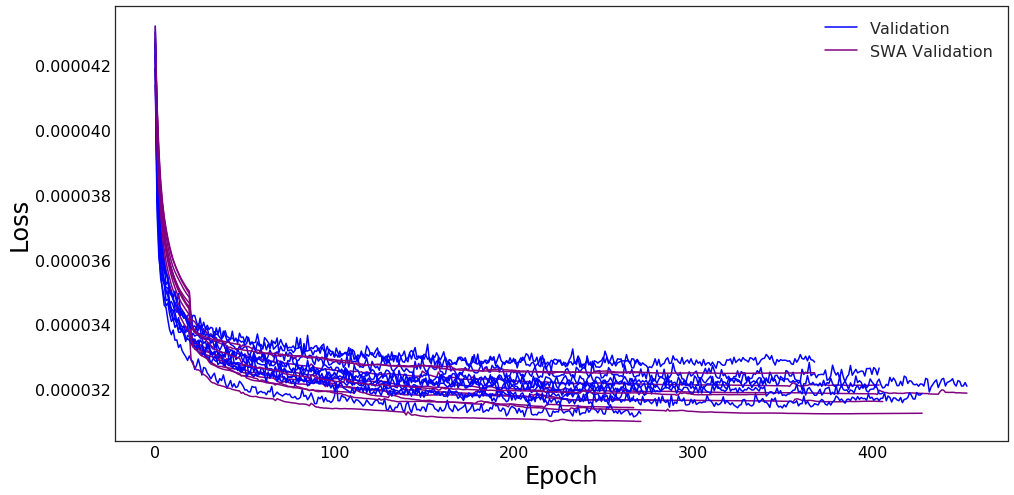

Mean loss = 3.18e-05 +- 1e-07
Mean wAUC = 0.0633 +- 0.0005
Mean AUC = 0.0986 +- 0.0006
______________________________________



In [15]:
results, histories = _batchTrainClassifier(trainData, nSplits, getModel, modelParams, trainParams,
                                          swaStart=1, swaRenewal=5,
                                          patience=50, cosAnnealMult=1, reduxDecay=False, trainOnWeights=True,
                                          maxEpochs=maxEpochs, verbose=1)

## Construct ensemble

In [ ]:
with open('train_weights/resultsFile.pkl', 'r') as fin:   
    results = pickle.load(fin)

In [ ]:
ensemble, weights = assembleEnsemble(results, ensembleSize, ensembleMode, compileArgs)

## Response on val data

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=16)

In [ ]:
pred = []
for i in xrange(10):
    tmpPred = []
    for aug in range(valData.augMult):
        batch = valData.getTestBatch(i, aug)['inputs']
        tmpPred.append(ensemblePredict(batch, ensemble, weights, n=1))
    pred.append(np.array(tmpPred))

In [ ]:
tPred = np.concatenate(pred, axis=1)

In [ ]:
df = pandas.DataFrame(getFeature('targets', valData.source), columns=['target'])

In [ ]:
for p in xrange(tPred.shape[0]):
    df['pred_'+ str(p)] = tPred[p,:]

In [ ]:
df.loc[:,'pred_mean'] = np.mean(df[[x for x in df.columns if 'pred' in x]], axis=1)

### Rot 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### Ref

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 4

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 8

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 10

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

### RotRef 16

In [ ]:
len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)])/len(df[(df.target == 1)])

In [ ]:
len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])/len(df[(df.target == 0)])

In [ ]:
(len(df[(df.target == 0) & (df.pred_0 < df.pred_mean)])+len(df[(df.target == 1) & (df.pred_0 > df.pred_mean)]))/len(df)

In [ ]:
def amsScanQuick(inData, wFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * wFactor),max(0,b * wFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

## Response on validation data base

In [ ]:
valData = BatchYielder(h5py.File(dirLoc + 'val.hdf5', "r+"))

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Ref

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = False, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 4

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=4)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 6

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=6)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 8

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=10)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = False, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 16

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 3

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=3)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

## Response on validation data Rot-Ref 5

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=5)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=5, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source))

# Final run

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=5, verbose=1)

In [ ]:
saveTest(0.9632657, 'Day_10_basic_rotref8_5')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_basic_rotref8_5_test.csv -m"Day_10 basic rotref8 5"

## Response on validation data Rot-Ref 8 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=0)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
cut = amsScanQuick(convertToDF(valData.source))[1]

In [ ]:
trainFrame = pandas.DataFrame()
trainFrame['gen_target'] = getFeature('targets', trainData.source)
trainFrame['gen_weight'] = getFeature('weights', trainData.source)
valFrame = convertToDF(valData.source)

In [ ]:
sigFactor = (len(trainFrame.loc[trainFrame.gen_target == 1, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 1, 'gen_weight'])
bkgFactor = (len(trainFrame.loc[trainFrame.gen_target == 0, 'gen_weight'])+len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight']))/len(valFrame.loc[valFrame.gen_target == 0, 'gen_weight'])
print sigFactor, bkgFactor

In [ ]:
def amsScanQuick(inData, sigFactor=250000./50000., bkgFactor=250000./50000.):
    s = np.sum(inData.loc[inData['gen_target'] == 1, 'gen_weight'])
    b = np.sum(inData.loc[inData['gen_target'] == 0, 'gen_weight'])
    tIIs = inData['pred_class'].argsort()
    amss = np.empty([len(tIIs)])
    
    amsMax = 0
    threshold = 0.0

    for tI in range(len(tIIs)):
        # don't forget to renormalize the weights to the same sum 
        # as in the complete training set
        amss[tI] = AMS(max(0,s * sigFactor),max(0,b * bkgFactor))
        if amss[tI] > amsMax:
            amsMax = amss[tI]
            threshold = inData['pred_class'].values[tIIs[tI]]
            #print tI,threshold
        if inData.loc[:, 'gen_target'].values[tIIs[tI]]:
            s -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
        else:
            b -= inData.loc[:, 'gen_weight'].values[tIIs[tI]]
    print amsMax, threshold
    return amsMax, threshold

In [ ]:
amsScanQuick(valFrame, sigFactor, bkgFactor)

In [ ]:
def amsScan(inData, scale=False):
    best = [0,-1]
    ams = []
    for index, row in inData.iterrows():
        s = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 1), 'gen_weight'])
        b = wFactor*np.sum(inData.loc[(inData['pred_class'] >= row['pred_class']) & (inData['gen_target'] == 0), 'gen_weight'])
        ams.append(AMS(s, b))
        if ams[-1] > best[1]:
            best = [row['pred_class'], ams[-1]]
    print best
    return ams, best

def foldAMSScan(inData, N=10):
    kf = StratifiedKFold(n_splits=N, shuffle=True)
    folds = kf.split(inData, inData['gen_target'])
    bests = []
    for i, (train, test) in enumerate(folds):
        bests.append(amsScan(inData.iloc[test], (np.sum(inData[(inData['gen_target'] == 1)]['gen_weight']), np.sum(inData[(inData['gen_target'] == 0)]['gen_weight'])))[1])
        print "Fold {}, best AMS {} at cut of {}. Total weights Signal:Bkg. {}:{}".format(i, bests[-1][1], bests[-1][0],
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 1]['gen_weight']),
                                                                                          np.sum(inData.iloc[test][inData.gen_target == 0]['gen_weight']))
    print "Mean cut", np.average([x[0] for x in bests], weights=[1/x[1] for x in bests]), "mean AMS", np.average([x[1] for x in bests], weights=[1/x[1] for x in bests])
    return bests

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print np.average([x[0] for x in bests])
print np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1.7448610687361392-x[1] for x in bests])
print np.average([x[0] for x in bests], weights=[1/np.abs(1.7448610687361392-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=8),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.9557010754710975, 'Day_10_M_rotref8_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_M_rotref8_10_test.csv -m"Day_10 minus rotref8 10"

## Response on validation data Rot-Ref 16 10

In [ ]:
with open(dirLoc + 'inputPipe.pkl', 'r') as fin:
    inputPipe = pickle.load(fin)

In [ ]:
valData = RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'val.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16)

In [ ]:
batchEnsemblePredict(ensemble, weights, valData, ensembleSize=10, verbose=1)

In [ ]:
print 'Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source)),
                                                           roc_auc_score(getFeature('targets', valData.source), getFeature('pred', valData.source), sample_weight=getFeature('weights', valData.source)))

In [ ]:
amsScanQuick(convertToDF(valData.source), 1, 1)

In [ ]:
bests = foldAMSScan(convertToDF(valData.source))

In [ ]:
print 'Mean', np.average([x[0] for x in bests])
print 'Inverse-AMS-weighted mean', np.average([x[0] for x in bests], weights=[1/x[1] for x in bests])
print 'AMS-weighted mean', np.average([x[0] for x in bests], weights=[x[1] for x in bests])
print 'AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1.7472080023156094-x[1] for x in bests])
print 'Inverse AMS-Difference-weighted mean', np.average([x[0] for x in bests], weights=[1/np.abs(1.7472080023156094-x[1]) for x in bests])

In [ ]:
batchEnsemblePredict(ensemble, weights, 
                     RotationReflectionBatch(classTrainFeatures, h5py.File(dirLoc + 'testing.hdf5', "r+"), inputPipe=inputPipe,
                                  rotate = True, reflect = True, augRotMult=16),
                     ensembleSize=10, verbose=1)

In [ ]:
saveTest(0.95, 'Day_10_95_rotref16_10')

In [ ]:
!kaggle competitions submit -c higgs-boson -f ../Data/Day_10_95_rotref16_10_test.csv -m"Day_10 95 rotref16 10"